In [1]:
!pip install torch torchvision
!pip install roboflow
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from google.colab import userdata

from numba import cuda


In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key=userdata.get("API_KEY"))
project = rf.workspace("data-science-173-msp9r").project("motorcycle-helmet-detection")
version = project.version(2)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Motorcycle-Helmet-Detection-2 in voc:: 100%|██████████| 4435/4435 [00:01<00:00, 2323.14it/s]


In [ ]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes (your dataset classes + 1 for background)
num_classes = 5  # For example, 2 classes + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
# Define transformations (e.g., resizing, normalization)
transform = T.Compose([
    T.ToTensor(),
])

LABEL_MAP = {"full-faced": 1,"half-faced": 2,  "invalid": 3,"no helmet":4}
# Custom Dataset class or using an existing one
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_dir, transforms=None):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms

        # List all XML annotation files
        self.image_files = []
        self.annotation_files = []

        for file in os.listdir(self.annotation_dir):
            if file.endswith(".xml"):
                self.annotation_files.append(os.path.join(self.annotation_dir, file))
                self.image_files.append(os.path.join(self.root_dir, file.replace(".xml", ".jpg")))  # Adjust if images are PNG

    def parse_annotation(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            if label in LABEL_MAP:
                labels.append(LABEL_MAP[label])

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        return boxes, labels

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        xml_path = self.annotation_files[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Load annotations
        boxes, labels = self.parse_annotation(xml_path)

        # Convert to PyTorch tensors
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        # Apply transforms if specified
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

In [ ]:


train_dataset = CustomDataset(root_dir="/content/Motorcycle-Helmet-Detection-2/train", annotation_dir="/content/Motorcycle-Helmet-Detection-2/train", transforms=transform)
valid_dataset = CustomDataset(root_dir="/content/Motorcycle-Helmet-Detection-2/valid", annotation_dir="/content/Motorcycle-Helmet-Detection-2/valid", transforms=transform)
test_dataset = CustomDataset(root_dir="/content/Motorcycle-Helmet-Detection-2/test", annotation_dir="/content/Motorcycle-Helmet-Detection-2/test", transforms=transform)
# Create data loaders
# print(train_dataset.image_files)
# print(f"boxes : {train_dataset.__getitem__.target['boxes']}")
# print(f"labels :{train_dataset.__getitem__.target['labels']}")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
os.environ['TORCH_CUDA_ALLOC_SYNC'] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
device = cuda.get_current_device()
# print(device)
torch.cuda.empty_cache()
device.reset()

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the device (this handles both dtype and device automatically)
model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop
    for images, targets in train_loader:
        # Check for empty targets and skip if necessary
        if any(len(t['boxes']) == 0 for t in targets):
            print("Skipping batch with empty bounding boxes.")
            continue

        # Move images and targets to device
        images = [image.to(device) for image in images]  # Ensure images are on the device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    # Update the learning rate
    lr_scheduler.step()
    print(f'Epoch: {epoch + 1}, Loss: {train_loss / len(train_loader)}')

print("Training complete!")

Output streaming akan dipotong hingga 5000 baris terakhir.
        [244., 376., 305., 549.],
        [454., 451., 500., 543.],
        [506., 462., 576., 598.]])
labels :tensor([2, 2, 2, 2])
boxes : tensor([[ 18., 355.,  82., 477.],
        [444., 331., 493., 422.],
        [393., 288., 447., 389.],
        [442., 354., 515., 461.],
        [409., 309., 447., 394.]])
labels :tensor([3, 2, 1, 2, 1])
boxes : tensor([[321., 359., 363., 458.],
        [472., 300., 510., 368.]])
labels :tensor([1, 1])
boxes : tensor([[128., 288., 166., 362.],
        [ 19., 300.,  65., 398.],
        [342., 343., 415., 455.]])
labels :tensor([2, 2, 1])
boxes : tensor([[458., 310., 499., 381.],
        [484., 441., 588., 573.]])
labels :tensor([1, 2])
boxes : tensor([[551., 319., 584., 409.]])
labels :tensor([1])
boxes : tensor([[  7., 346.,  53., 461.],
        [179., 312., 236., 407.],
        [232., 267., 258., 345.],
        [325., 309., 386., 397.],
        [542., 368., 590., 468.]])
labels :tensor([2, 

In [ ]:
# Set the model to evaluation mode
model.eval()
# Test on a new image
with torch.no_grad():
    for images, targets in valid_loader:
        images = list(img.to(device) for img in images)
        predictions = model(images)
        # Example: print the bounding boxes and labels for the first image

boxes : tensor([[  6., 346.,  57., 477.],
        [482., 353., 535., 449.]])
labels :tensor([2, 1])
boxes : tensor([[346., 277., 383., 361.]])
labels :tensor([1])
boxes : tensor([[405., 292., 445., 391.],
        [592., 318., 625., 382.]])
labels :tensor([3, 2])
boxes : tensor([[590., 318., 623., 382.],
        [260., 344., 298., 479.],
        [412., 278., 452., 345.]])
labels :tensor([2, 2, 2])
boxes : tensor([[459., 309., 500., 380.],
        [201., 333., 246., 452.]])
labels :tensor([1, 2])
boxes : tensor([[147., 401., 227., 532.],
        [611., 317., 626., 348.],
        [404., 295., 427., 326.],
        [586., 311., 607., 367.],
        [458., 295., 489., 352.],
        [378., 348., 439., 469.],
        [338., 297., 365., 354.]])
labels :tensor([2, 1, 1, 2, 2, 2, 1])
boxes : tensor([[131., 343., 190., 462.],
        [ 94., 312., 128., 397.]])
labels :tensor([2, 1])
boxes : tensor([[ 18., 355.,  82., 477.],
        [444., 331., 493., 422.],
        [405., 294., 459., 395.]])
labe

In [ ]:
torch.save(model.state_dict(), "/content/faster_rcnn.pt")

In [ ]:
import cv2
from PIL import Image
# Load image
img = Image.open("/content/14_58_04.298625.png")
# Apply the same transformation as for training
img = transform(img)
# img = img.unsqueeze(0).to(device) # Remove this line
img = img.to(device) # Move the image to the device
# Model prediction
model.eval()
with torch.no_grad():
    prediction = model([img]) # Pass the image as a single-element list
# Print the predicted bounding boxes and labels
print(prediction[0]['boxes'])
print(prediction[0]['labels'])

tensor([[1247.1156,  436.7682, 1334.3638,  601.4322],
        [ 739.9540,  283.0913,  809.1162,  394.6007],
        [1107.3999,  302.5621, 1189.4731,  438.8260],
        [1154.3429,  643.2702, 1298.7360,  868.4368],
        [1013.8705,  280.0436, 1080.2230,  383.0889],
        [1154.4368,  646.9331, 1288.8254,  872.7227],
        [ 326.4418,  460.6374,  420.6809,  625.6302],
        [ 326.3066,  468.9503,  419.6076,  625.6235],
        [ 326.2661,  463.5140,  422.6141,  612.4546],
        [ 742.5333,  278.9694,  810.5850,  394.6566],
        [1246.6780,  433.8700, 1334.4050,  607.9083],
        [ 752.9894,  286.3217,  801.2159,  352.1419],
        [1014.9081,  277.3727, 1081.3340,  381.5547],
        [ 333.8971,  472.4505,  416.4954,  616.2466],
        [1110.0031,  308.1725, 1188.6891,  436.3439],
        [1020.3940,  285.5189, 1074.7166,  347.9560]], device='cuda:0')
tensor([2, 2, 2, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 4, 1, 2], device='cuda:0')


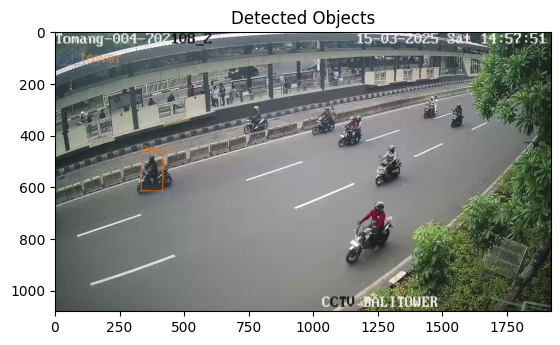

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import random
import colorsys

# Load image
img = Image.open("/content/14_58_04.298625.png")
# Apply the same transformation as for training
img_tensor = transform(img)
img_tensor = img_tensor.to(device)

# Model prediction
model.eval()
with torch.no_grad():
    prediction = model([img_tensor])

# Get boxes, labels, and scores
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# **Reduced Confidence Threshold**
keep_indices = scores > 0.1  # **Threshold reduced to 0.3**
filtered_boxes = boxes[keep_indices]
filtered_labels = labels[keep_indices]

# Convert the image tensor to a NumPy array for display
img_np = img_tensor.cpu().permute(1, 2, 0).numpy()

# Convert img_np to the correct data type (uint8)
img_np = (img_np * 255).astype(np.uint8) # Convert to uint8 for OpenCV

# Draw bounding boxes
for box, label in zip(filtered_boxes, filtered_labels): # Use filtered boxes and labels
    box = box.cpu().numpy()  # Convert box coordinates to CPU
    x1, y1, x2, y2 = box.astype(int)  # Convert coordinates to integers

    # Generate a random color for each box
    hue = random.random()
    color = colorsys.hsv_to_rgb(hue, 1, 1)
    color_bgr = [int(c * 255) for c in color[::-1]] # Convert to BGR for OpenCV

    # Convert img_np to BGR color format if it's in RGB
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color_bgr, 2)  # Draw rectangle on img_bgr

    # Add label text
    label_text = f"Class: {label.item()}"  # Get label as an integer
    cv2.putText(img_bgr, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color_bgr, 2)

# Display the image using Matplotlib
# Convert back to RGB for Matplotlib display if needed
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Detected Objects")
plt.show()

In [12]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import random
import colorsys
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load image
img = Image.open("/content/14_58_40.636678.png")
# Apply the same transformation as for training
img_tensor = transform(img)
img_tensor = img_tensor.to(device)

# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes (your dataset classes + 1 for background)
num_classes = 5  # This should match the number of classes used during training

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/faster_rcnn.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict) # Load the state_dict into the model instance

model.eval() # Now you can call eval() on th

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [59]:
import cv2
from PIL import Image
# Load image
img = Image.open("/content/14_58_22.112800.png")
# Apply the same transformation as for training
img = transform(img)
# img = img.unsqueeze(0).to(device) # Remove this line
img = img.to(device) # Move the image to the device

with torch.no_grad():
    prediction = model([img]) # Pass the image as a single-element list
# Print the predicted bounding boxes and labels
print(prediction[0]['boxes'])
print(prediction[0]['labels'])

tensor([[ 780.9768,  327.9514,  851.6877,  431.6227],
        [ 834.0546,  807.9438, 1015.6364, 1045.6945],
        [  63.0402,  550.2159,  159.7825,  716.3248],
        [ 943.0117,  534.5229, 1076.7107,  734.2666],
        [ 420.3110,  341.0845,  507.6354,  478.1203],
        [ 948.4058,  528.9360, 1092.3850,  721.9330],
        [ 831.6426,  799.2819, 1022.7925, 1041.5659],
        [ 875.0919,  362.2574,  965.2895,  517.9779],
        [  64.7556,  546.9411,  161.3351,  713.6407],
        [  61.5714,  542.1039,  166.6645,  710.2092],
        [ 783.7678,  325.3362,  857.0490,  434.9771],
        [ 876.0991,  365.9935,  963.3733,  517.1790],
        [ 955.8625,  530.4843, 1085.9359,  716.7343],
        [ 793.2048,  328.8265,  848.0385,  395.4980],
        [  63.4795,  547.0309,  167.8610,  701.5138],
        [ 423.8048,  344.1502,  505.6839,  472.4726]])
tensor([2, 2, 2, 2, 2, 1, 1, 2, 1, 3, 1, 1, 3, 2, 4, 1])


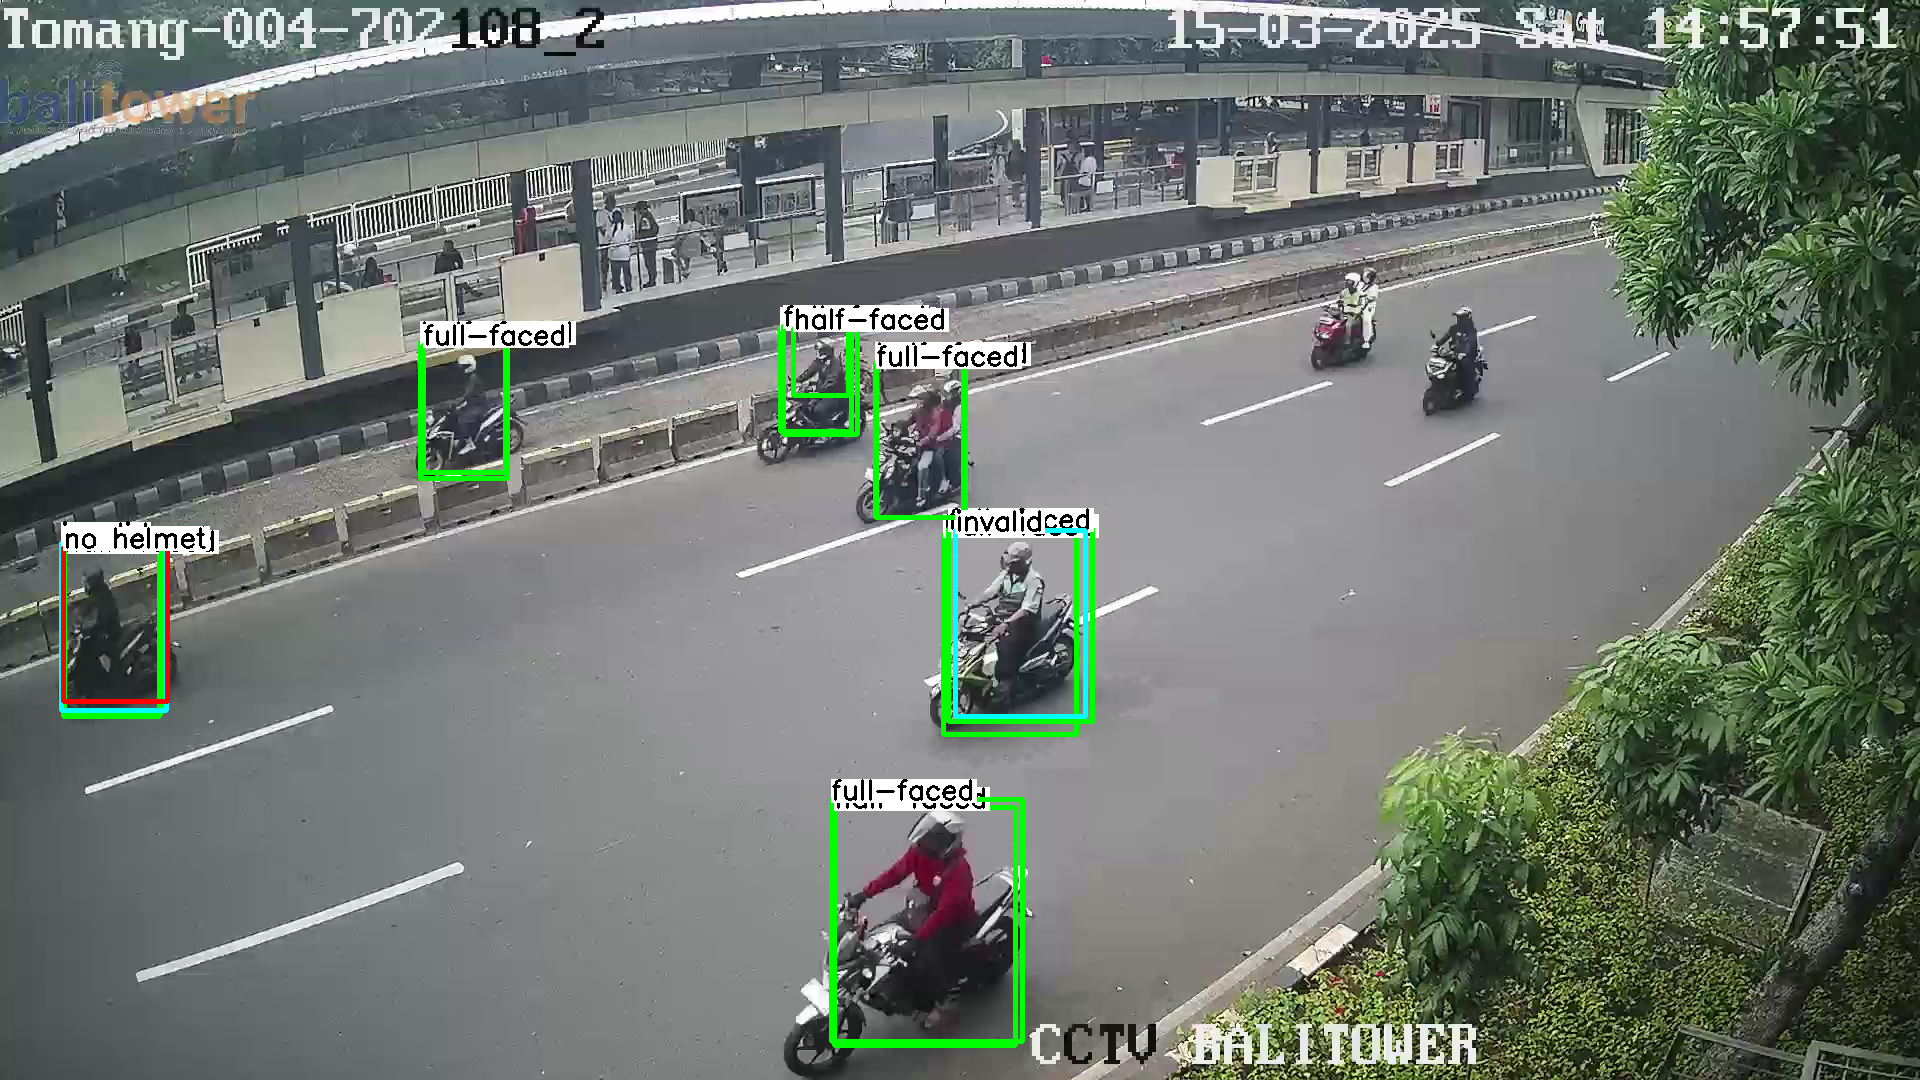

780.9768


In [72]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/14_58_22.112800.png")

for i in range(len(prediction[0]['boxes'])):
  # for i in range(len())
      x, y, w, h = prediction[0]['boxes'][i].numpy().astype('int')
      classes = {1:"full-faced",2:"half-faced",3:"invalid",4:"no helmet"}
      text = classes[prediction[0]['labels'][i].item()]
      # print(x,y)
      if text == "full-faced" or text == "half-faced":
        color = (0,255,0)
      elif text == "invalid":
        color = (255,255,0)
      elif text == "no helmet":
        color = (0,0,255)
      cv2.rectangle(image,(x,y),(w,h),color,4)
      text_size, _ = cv2.getTextSize(text,cv2.FONT_HERSHEY_SIMPLEX , 0.9, 2)
      text_w, text_h = text_size
      cv2.rectangle(image, (x,y-text_h), (x + text_w, y + text_h-17), (255,255,255), cv2.FILLED)
      cv2.putText(image,text,(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,0,0),2)


cv2_imshow(image)

print(prediction[0]['boxes'][0][0].numpy())